In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
import matplotlib.pyplot as chart
import seaborn as chart1
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator as more_variations
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.initializers import glorot_uniform
from keras.models import model_from_json
import cv2
import os as opsys
import numpy as NUMPY
from tqdm import tqdm
from keras import backend as K
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD , Adam , Adadelta, Adagrad, Adamax,Nadam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Dropout as drop
from keras.layers import Input, Add, Dense, ZeroPadding2D,  Flatten
from keras.layers import ZeroPadding2D as ZPad 
from keras.layers import Activation as non_linear_activation
from keras.layers import Conv2D as CNV_layer
from keras.layers import BatchNormalization as batch_norm
from keras.layers import MaxPooling2D as MP
from keras.layers import AveragePooling2D as AP
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.utils import to_categorical , plot_model

In [72]:
def data_reading(dir):
    d = [] 
    for L in labels: 
        P , class_num = opsys.path.join(dir, L) , labels.index(L)
        for I in opsys.listdir(P):
            try:
                d.append([cv2.resize(cv2.imread(opsys.path.join(P, I)), (img_size, img_size)), class_num])
            except Exception as e:
                print(e)
    return NUMPY.array(d)

In [73]:
def get_visuvalization(Inf):
      F = []
      for G in Inf:
          if(G[1] == 0):
              F.append("Pneumonia")
          else:
              F.append("Normal")
      chart1.set_style('darkgrid')
      ax = chart1.countplot(F)

In [74]:
def display(information):
    chart.figure(figsize = (7,7))
    chart.imshow(information[0][0], cmap='gray')
    chart.title(labels[information[0][1]])

    chart.figure(figsize = (7,7))
    chart.imshow(train[-1][0], cmap='gray')
    chart.title(labels[information[-1][1]])

In [75]:
labels , img_size  = ['PNEUMONIA', 'NORMAL'] ,150

train = data_reading('/content/drive/MyDrive/lung_disease/Pediatric Chest X-ray Pneumonia/train')
test = data_reading('/content/drive/MyDrive/lung_disease/Pediatric Chest X-ray Pneumonia/test')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


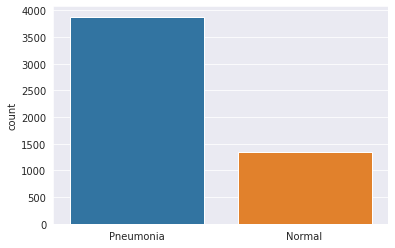

In [76]:
get_visuvalization(train)

In [77]:
train = data_reading('/content/drive/MyDrive/lung_disease_undersampling')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


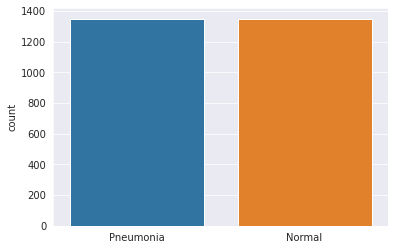

In [78]:
get_visuvalization(train)

In [79]:
print("Size of training data",len(train))
print("Size of testing data",len(test))

Size of training data 2698
Size of testing data 624


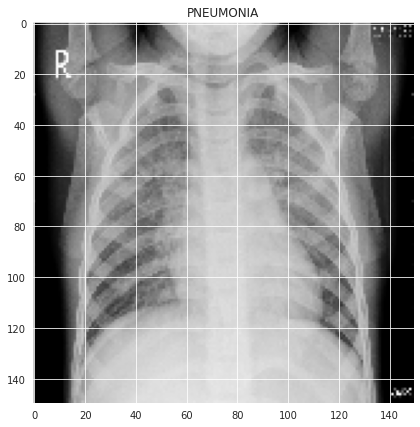

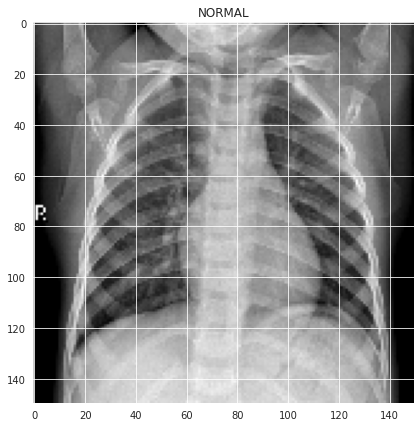

In [80]:
display(train)

In [81]:
train_datagen = more_variations(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,validation_split=0.2)
test_datagen = more_variations()


In [82]:
train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/lung_disease_undersampling",target_size=(150, 150),batch_size=2,shuffle=True,class_mode='binary',subset='training')
val_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/lung_disease_undersampling",target_size=(150,150),batch_size=2,shuffle=False,class_mode='binary',subset='validation')
test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/lung_disease/Pediatric Chest X-ray Pneumonia/test",target_size=(150,150),batch_size=5,shuffle=False,class_mode='binary')

Found 2160 images belonging to 2 classes.
Found 538 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## ResNet 50 Implementation

In [83]:
def IB(L, f, filters, stage, block):

    Filter1, Filter2, Filter3 = filters

    L_shortcut = L
   
    L = CNV_layer(filters=Filter1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name='res' + str(stage) + block + '_branch' + '2a', kernel_initializer=glorot_uniform(seed=0))(L)
    L = batch_norm(axis=3, name='bn' + str(stage) + block + '_branch' + '2a')(L)
    L = non_linear_activation('relu')(L)

    L = CNV_layer(filters=Filter2, kernel_size=(f, f), strides=(1, 1), padding='same', name='res' + str(stage) + block + '_branch' + '2b', kernel_initializer=glorot_uniform(seed=0))(L)
    L = batch_norm(axis=3, name='bn' + str(stage) + block + '_branch' + '2b')(L)
    L = non_linear_activation('relu')(L)

    L = CNV_layer(filters=Filter3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name='res' + str(stage) + block + '_branch' + '2c', kernel_initializer=glorot_uniform(seed=0))(L)
    L = batch_norm(axis=3, name='bn' + str(stage) + block + '_branch' + '2c')(L)

    L = Add()([L, L_shortcut])# SKIP Connection
    L = non_linear_activation('relu')(L)

    return L

In [84]:
def CB(L, f, filters, stage, block, s=2):
   

    Filter1, Filter2, Filter3 = filters

    L_shortcut = L

    L = CNV_layer(filters=Filter1, kernel_size=(1, 1), strides=(s, s), padding='valid', name='res' + str(stage) + block + '_branch' + '2a', kernel_initializer=glorot_uniform(seed=0))(L)
    L = batch_norm(axis=3, name='bn' + str(stage) + block + '_branch' + '2a')(L)
    L = non_linear_activation('relu')(L)

    L = CNV_layer(filters=Filter2, kernel_size=(f, f), strides=(1, 1), padding='same', name='res' + str(stage) + block + '_branch' + '2b', kernel_initializer=glorot_uniform(seed=0))(L)
    L = batch_norm(axis=3, name='bn' + str(stage) + block + '_branch' + '2b')(L)
    LookupError = non_linear_activation('relu')(L)

    L = CNV_layer(filters=Filter3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name='res' + str(stage) + block + '_branch' + '2c', kernel_initializer=glorot_uniform(seed=0))(L)
    L = batch_norm(axis=3, name='bn' + str(stage) + block + '_branch' + '2c')(L)

    L_shortcut = CNV_layer(filters=Filter3, kernel_size=(1, 1), strides=(s, s), padding='valid', name='res' + str(stage) + block + '_branch' + '1', kernel_initializer=glorot_uniform(seed=0))(L_shortcut)
    L_shortcut = batch_norm(axis=3, name='bn' + str(stage) + block + '_branch' + '1')(L_shortcut)

    L = Add()([L, L_shortcut])
    L = non_linear_activation('relu')(L)

    return L

In [85]:
def ResNet50(input_shape=(224, 224, 3)):

    L_input = Input(input_shape)

    L = ZPad((3, 3))(L_input)

    L = CNV_layer(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(L)
    L = batch_norm(axis=3, name='bn_conv1')(L)
    L = non_linear_activation('relu')(L)
    L = MP((3, 3), strides=(2, 2))(L)

    L = CB(L, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    L = IB(L, 3, [64, 64, 256], stage=2, block='b')
    L = IB(L, 3, [64, 64, 256], stage=2, block='c')


    L = CB(L, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    L = IB(L, 3, [128, 128, 512], stage=3, block='b')
    #X = IB(X, 3, [128, 128, 512], stage=3, block='c')
    L = IB(L, 3, [128, 128, 512], stage=3, block='d')

    L = CB(L, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    L = IB(L, 3, [256, 256, 1024], stage=4, block='b')
    L = IB(L, 3, [256, 256, 1024], stage=4, block='c')
    #X = IB(X, 3, [256, 256, 1024], stage=4, block='d')
    #X = IB(X, 3, [256, 256, 1024], stage=4, block='e')
    L = IB(L, 3, [256, 256, 1024], stage=4, block='f')

    L = CB(L, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    L = IB(L, 3, [512, 512, 2048], stage=5, block='b')
    #X = IB(X, 3, [512, 512, 2048], stage=5, block='c')

    L = AP(pool_size=(2, 2), padding='same')(L)
    
    model = Model(inputs=L_input, outputs=L, name='ResNet50')

    return model

In [86]:
adapt = ResNet50(input_shape=(150, 150, 3))

In [87]:
adapt_design = adapt.output
adapt_design = Flatten()(adapt_design)
adapt_design = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(adapt_design)
adapt_design = drop(rate = 0.5)(adapt_design)
adapt_design = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(adapt_design)
adapt_design = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(adapt_design)

In [88]:
Adapt = Model(inputs=adapt.input, outputs=adapt_design)

In [89]:
Adapt.compile(optimizer = "Adamax" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [90]:
Adapt.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 156, 156, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 75, 75, 64)   9472        ['zero_padding2d_2[0][0]']       
                                                                                            

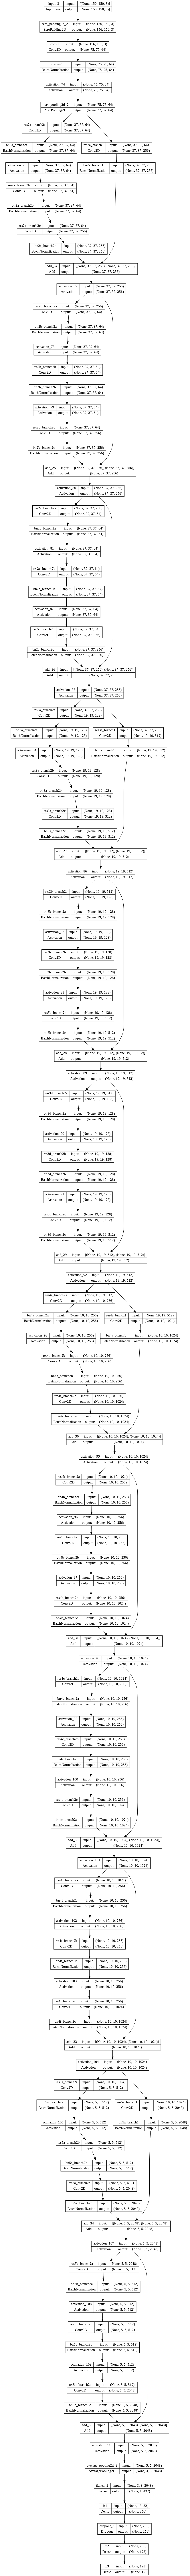

In [91]:
plot_model(Adapt,show_shapes = True)

In [92]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=0,factor=0.3, min_lr=0.0001)
checkpoint = ModelCheckpoint("model.h5",monitor='val_accuracy',save_best_only=True,mode="auto",verbose=1)

In [93]:
mc = ModelCheckpoint('/content/gdrive/My Drive/best_model.h5', monitor='val_accuracy', mode='max')

In [94]:
H = Adapt.fit(train_generator,validation_data=val_generator,epochs=50,verbose=1,callbacks=[learning_rate_reduction,checkpoint])

Epoch 1/50
1080/1080 [==============================] - ETA: 0s - loss: 1.1193 - accuracy: 0.6741
Epoch 1: val_accuracy improved from -inf to 0.70632, saving model to model.h5
1080/1080 [==============================] - 84s 72ms/step - loss: 1.1193 - accuracy: 0.6741 - val_loss: 0.6755 - val_accuracy: 0.7063 - lr: 0.0010
Epoch 2/50
1079/1080 [============================>.] - ETA: 0s - loss: 0.5501 - accuracy: 0.7465
Epoch 2: val_accuracy improved from 0.70632 to 0.74721, saving model to model.h5
1080/1080 [==============================] - 79s 73ms/step - loss: 0.5498 - accuracy: 0.7468 - val_loss: 0.5318 - val_accuracy: 0.7472 - lr: 0.0010
Epoch 3/50
1079/1080 [============================>.] - ETA: 0s - loss: 0.5200 - accuracy: 0.7641
Epoch 3: val_accuracy improved from 0.74721 to 0.78067, saving model to model.h5
1080/1080 [==============================] - 77s 71ms/step - loss: 0.5197 - accuracy: 0.7644 - val_loss: 0.4612 - val_accuracy: 0.7807 - lr: 0.0010
Epoch 4/50
1080/1080 [

In [95]:
def get_history_plots(epochs,Q):
    # epochs = [R for R in range(epochs)]
    fig , X = chart.subplots(1,2)
    fig.set_size_inches(15,10)

    X[0].plot([R for R in range(epochs)] , Q.history['accuracy'] ,'g' , label = 'Training Accuracy')
    X[0].plot([R for R in range(epochs)] , Q.history['val_accuracy'] ,'r', label = 'Validation Accuracy')
    X[0].set_title('Training & Validation Accuracy')
    X[0].legend()
    X[0].set_xlabel("Epochs")
    X[0].set_ylabel("Accuracy")

    X[1].plot([R for R in range(epochs)] , Q.history['loss'] , 'g' , label = 'Training Loss')
    X[1].plot([R for R in range(epochs)] , Q.history['val_loss'] , 'r' , label = 'Validation Loss')
    X[1].set_title('Training Accuracy & Loss')
    X[1].legend()
    X[1].set_xlabel("Epochs")
    X[1].set_ylabel("Training & Validation Loss")
    chart.show()

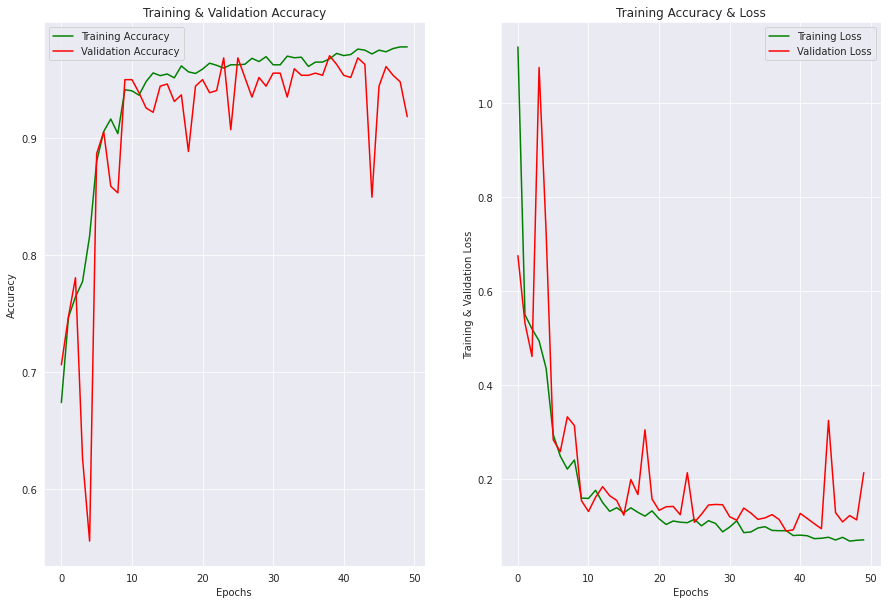

In [96]:
get_history_plots(50,H)

In [97]:
Adapt.evaluate(test_generator)

125/125 [==============================] - 9s 74ms/step - loss: 0.2103 - accuracy: 0.9151


[0.21032512187957764, 0.9150640964508057]

In [98]:
Y_pred = Adapt.predict(test_generator)

125/125 [==============================] - 9s 63ms/step


In [99]:
P = []
for Y in range(0,len(Y_pred)):
  if Y_pred[Y] >= 0.5:
    P.append(1)
  else:
    P.append(0)


Confusion Matrix


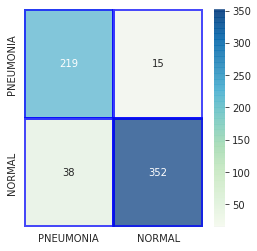

In [100]:
print('Confusion Matrix')
FIGU,Axs=chart.subplots(1,1,figsize=(4,4))
chart1.heatmap(confusion_matrix(test_generator.classes, P),ax=Axs,xticklabels=labels,yticklabels=labels,annot=True,
              cmap='GnBu',alpha=0.7,linewidths=2,linecolor='blue',fmt = 'd')

In [101]:
print('Classification Report')
print(classification_report(test_generator.classes, P, target_names=labels))

Classification Report
              precision    recall  f1-score   support

   PNEUMONIA       0.85      0.94      0.89       234
      NORMAL       0.96      0.90      0.93       390

    accuracy                           0.92       624
   macro avg       0.91      0.92      0.91       624
weighted avg       0.92      0.92      0.92       624



# Under Sampling

In [102]:
# import random as rd
# import shutil as sh

# data_list = []
# lab = 'PNEUMONIA'
# for root, dirs, folders in opsys.walk("/content/drive/MyDrive/lung_disease_undersampling/PNEUMONIA"):
#     for F in folders:
#         if F.endswith(".jpg") or F.endswith(".png") or F.endswith(".jpeg"):
#             data_list.append(opsys.path.join(root, F))

# file_count = len(data_list)

# selected_files = rd.sample(data_list, 134) 

# opsys.mkdir(f"/content/drive/MyDrive/sam/{lab}")

# for sp in selected_files:
#     sh.copy(sp, opsys.path.join(f"/content/drive/MyDrive/sam/{lab}", opsys.path.basename(sp)))